## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [43]:
mal_data = pd.read_excel('WHO_Child_Growth_Malnutrition_Data_Export_Selected_Countries_Short(1).xlsx', sheet_name='Data')

## Data Cleaning

In [ ]:
mal_data.isnull().sum()

In [3]:
mal_data.drop(columns=['Year period','Representation level', 'Region', 'Other group/Zone', 'Notes', 'Reference Title', 'JME (Y/N)'], inplace=True)

In [ ]:
mal_data.isnull().sum()

In [4]:
for column in ['Wasting','Stunting','Severe wasting','Overweight','Underweight']:
    mal_data[column].interpolate(method='linear',inplace=True, limit_direction="both")

In [ ]:
mal_data.isnull().sum()

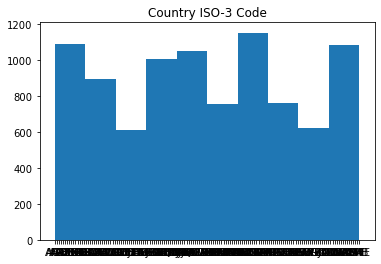

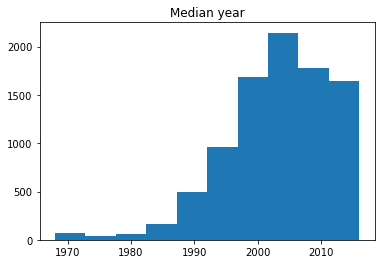

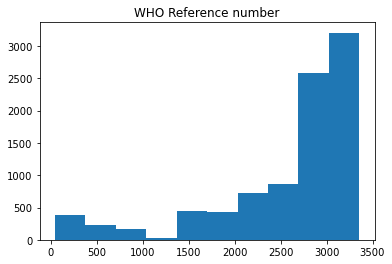

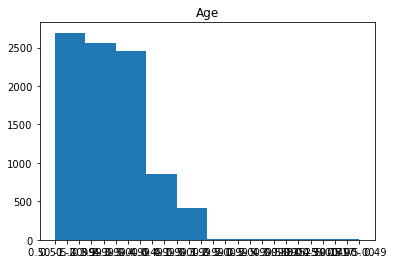

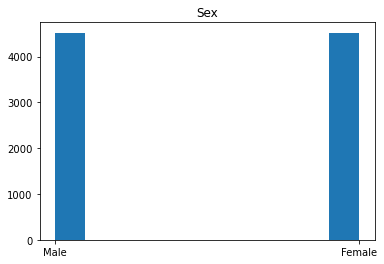

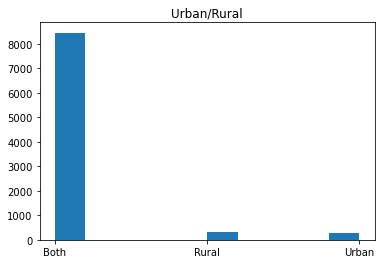

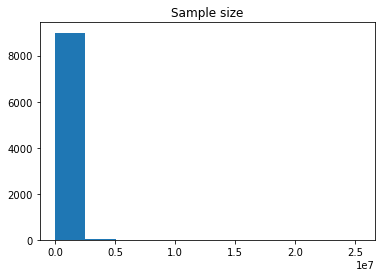

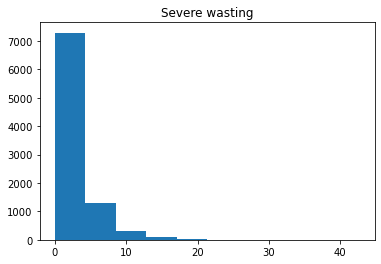

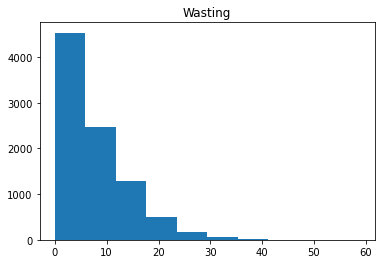

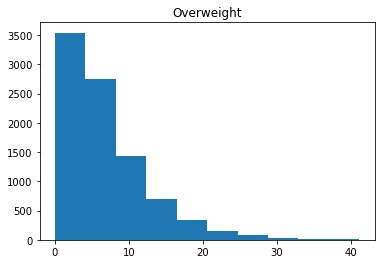

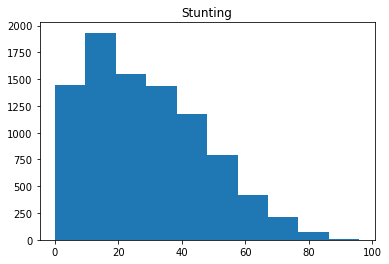

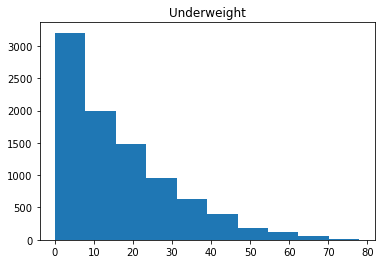

In [5]:
for i in mal_data.columns:
    plt.figure()
#     print(i)
    try:
        
        plt.hist(mal_data[i])
        plt.title(i)
    except:
        pass

In [ ]:
mal_data.columns

In [6]:
mal_data.columns = ["_".join(col.split(' ')).lower() for col in mal_data.columns]

In [7]:
mal_data['sample_size'] = np.log(mal_data['sample_size']+1)

In [8]:
mal_data['stunting'] = np.sqrt(mal_data['stunting'])

In [9]:
mal_data['underweight'] = np.sqrt(mal_data['underweight'])

In [10]:
mal_data['overweight'] = np.sqrt(mal_data['overweight'])

In [11]:
mal_data['severe_wasting'] = np.cbrt(mal_data['severe_wasting'])

In [12]:
mal_data['wasting'] = np.sqrt(mal_data['wasting'])

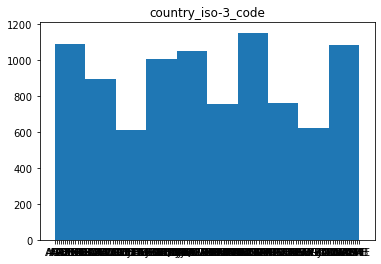

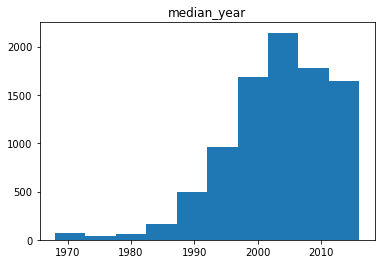

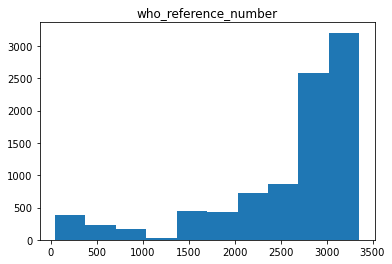

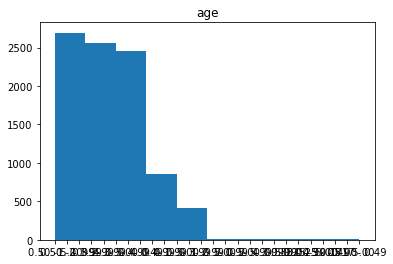

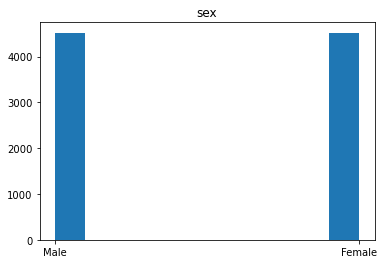

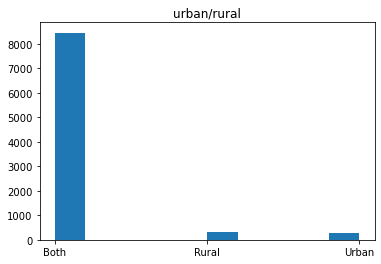

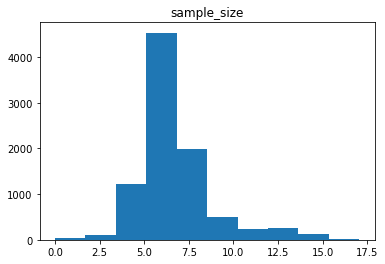

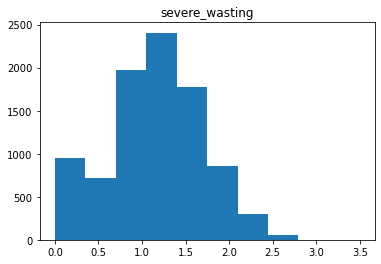

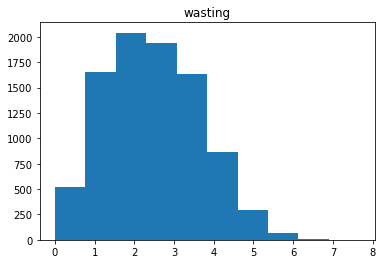

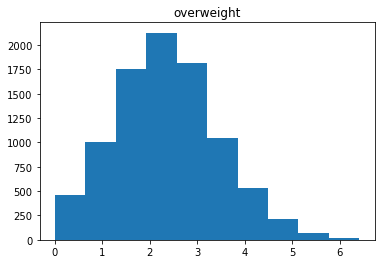

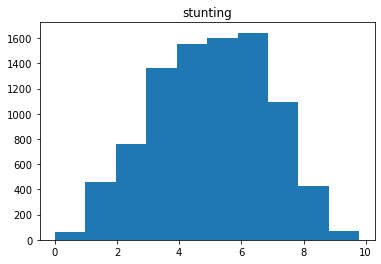

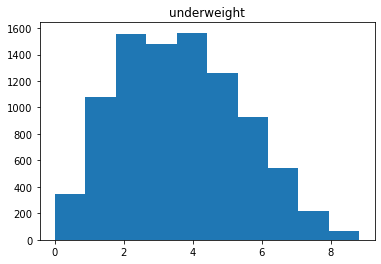

In [13]:
for i in mal_data.columns:
    plt.figure()
#     print(i)
    plt.hist(mal_data[i])
    plt.title(i)

## Data Encoding

In [14]:
country_encd_mean = mal_data.groupby('country_iso-3_code')['stunting'].mean()
mal_data['country_encd_mean'] = mal_data['country_iso-3_code'].map(country_encd_mean)
mal_data[['country_iso-3_code', 'country_encd_mean']].head()

,country_iso-3_code,country_encd_mean
0,AFG,7.585121
1,AFG,7.585121
2,AFG,7.585121
3,AFG,7.585121
4,AFG,7.585121


In [15]:
encoded_data = mal_data.drop(columns='country_iso-3_code')

In [16]:
encoded_data['age_encoded'] = LabelEncoder().fit_transform(encoded_data['age'])

In [17]:
encoded_data.drop(columns = 'age', inplace=True)

In [18]:
encoded_data['sex'] = LabelEncoder().fit_transform(encoded_data['sex'])
encoded_data['urban/rural'] = LabelEncoder().fit_transform(encoded_data['urban/rural'])

In [19]:
encoded_data['median_year_new'] = LabelEncoder().fit_transform(encoded_data['median_year'])
encoded_data['who_reference_number_new'] = LabelEncoder().fit_transform(encoded_data['who_reference_number'])

## Correlation

<AxesSubplot:>

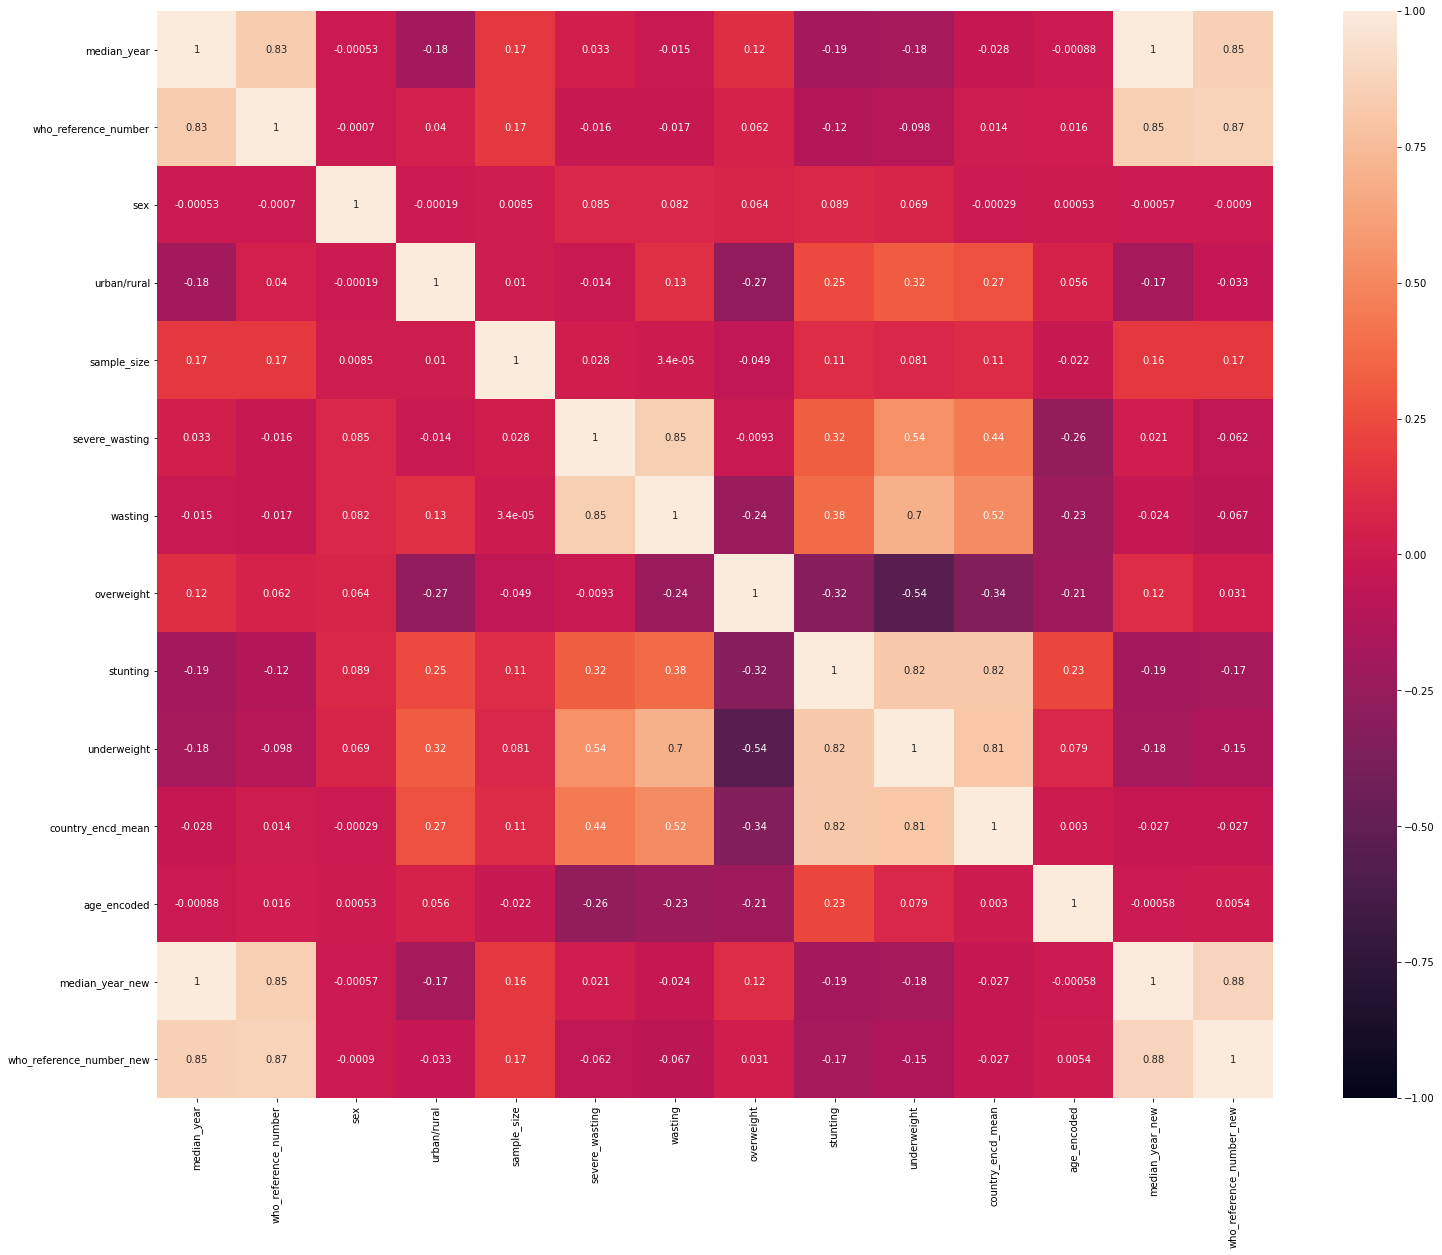

In [20]:

plt.figure(figsize=(25, 20))
sns.heatmap(encoded_data.corr(), vmin=-1, vmax=1, annot=True)

In [21]:
cols_to_use = [col for col in encoded_data.columns if col not in ['who_reference_number', 'who_reference_number_new', 'wasting', 'country_encd_mean', 'median_year']]
final_df = encoded_data[cols_to_use]

In [ ]:
encoded_data[['median_year','median_year_new']].value_counts()

<AxesSubplot:>

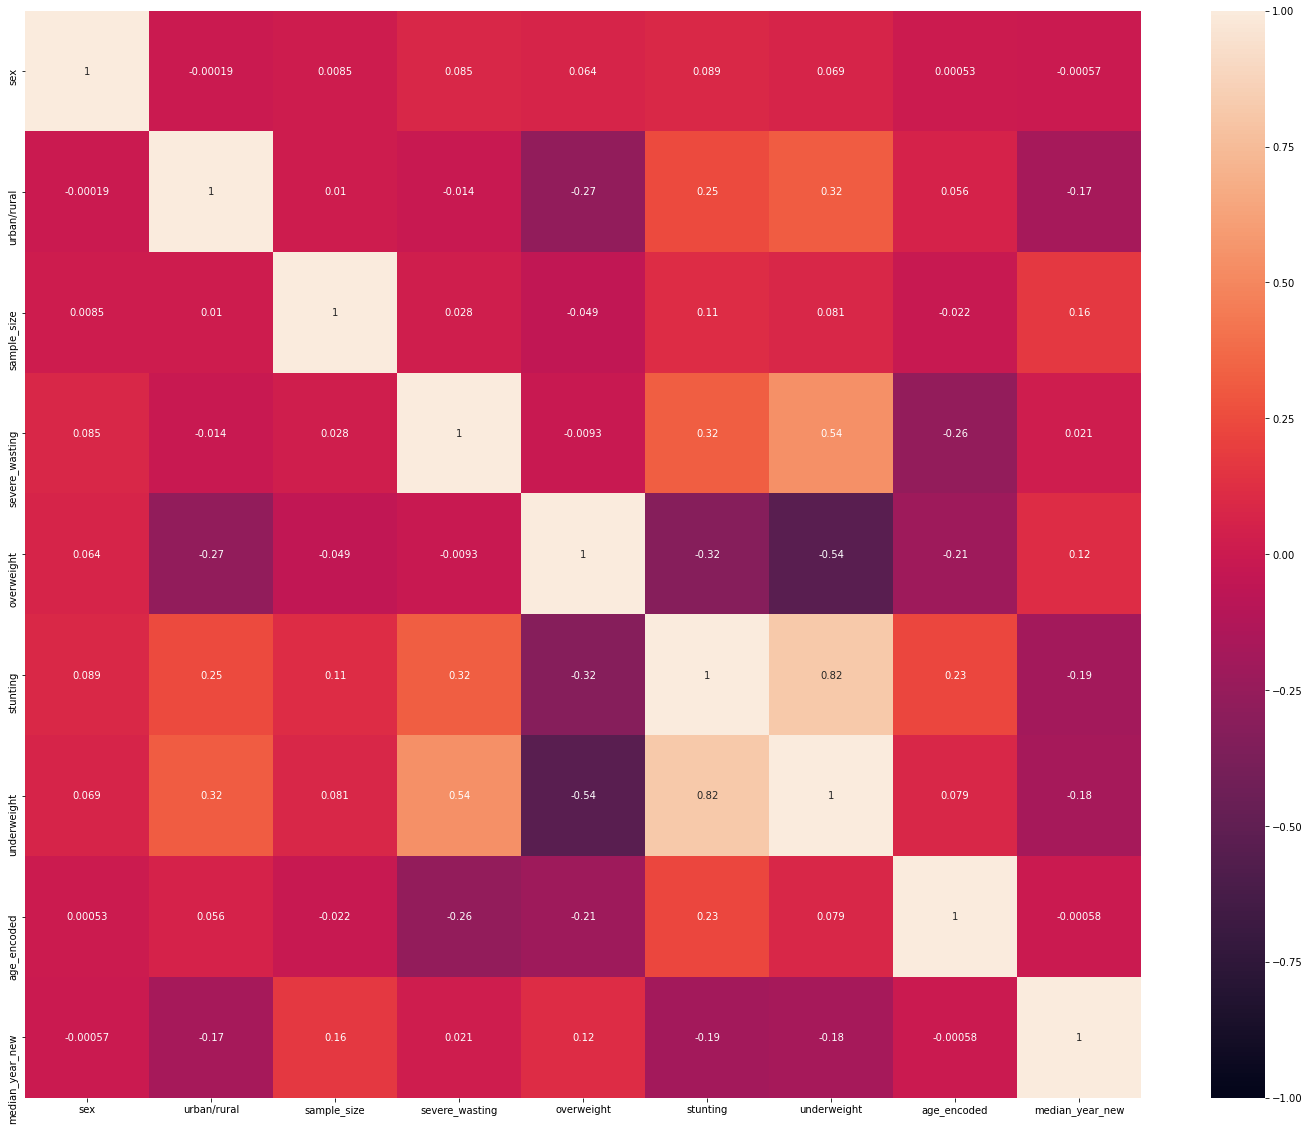

In [22]:
plt.figure(figsize=(25, 20))
sns.heatmap(final_df.corr(), vmin=-1, vmax=1, annot=True)

In [ ]:
encoded_data.dtypes

In [ ]:
for i in final_df.columns:
    plt.figure()
#     print(i)
    plt.hist(final_df[i])
    plt.title(i)

## Train Test Split

In [23]:
X_training_data = final_df[~final_df['median_year_new'].isin([38, 39])].drop(columns=['stunting'])
X_testing_data = final_df[final_df['median_year_new'].isin([38, 39])].drop(columns=['stunting'])
target_train = final_df[~final_df['median_year_new'].isin([38, 39])]['stunting']
target_test  = final_df[final_df['median_year_new'].isin([38, 39])]['stunting']

In [27]:
X_training_data.shape

(8643, 8)

## Component Selection

In [ ]:
X_training_data.shape

In [ ]:
######Principal Component Analysis
pca = PCA(n_components=3) # estimate PCs
X_training_new = pca.fit_transform(X_training_data)
X_testing_new = pca.fit_transform(X_testing_data)

In [ ]:
print(np.round(pca.explained_variance_ratio_, 2))
print(pd.DataFrame(pca.components_,columns=X_training_data.columns))

## Linear Regression

In [28]:
# Note the difference in argument order
model = sm.OLS(target_train, X_training_data).fit()
train_predictions = model.predict(X_training_data) # make the predictions by the model
test_predictions = model.predict(X_testing_data) # make the predictions by the model
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               stunting   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          3.644e+04
Date:                Sat, 01 May 2021   Prob (F-statistic):                        0.00
Time:                        13:07:54   Log-Likelihood:                         -11452.
No. Observations:                8643   AIC:                                  2.292e+04
Df Residuals:                    8635   BIC:                                  2.298e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sex                 0.0527      0.020      2.667      0.008       0.014       0.091
urban/rural        -0.1662      0.028     -5.974      0.000      -0.221      -0.112
sample_size         0.0537      0.004     12.253      0.000       0.045       0.062
severe_wasting     -0.6623      0.024    -27.434      0.000      -0.710      -0.615
overweight          0.4779      0.010     49.944      0.000       0.459       0.497
underweight         1.1087      0.008    134.359      0.000       1.093       1.125
age_encoded         0.0372      0.001     28.224      0.000       0.035       0.040
median_year_new    -0.0109      0.001     -9.127      0.000      -0.013      -0.009
==============================================================================
Omnibus:                      724.096   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2420.764
Skew:                          -0.406   Prob(JB):                         0.00
Kurtosis:                       5.462   Cond. No.                         94.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
import plotly.express as px
px.scatter( x = target_test, y=test_predictions, trendline='ols', trendline_color_override="red")

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


C:\Users\cheta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Residual plot')

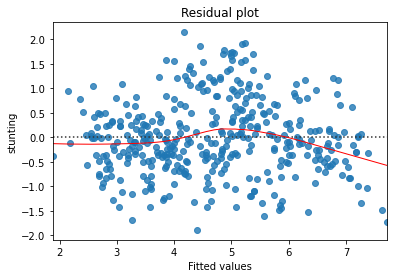

In [32]:
sns.residplot(test_predictions,target_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Text(0.5, 1.0, 'Normal Q-Q Plot')

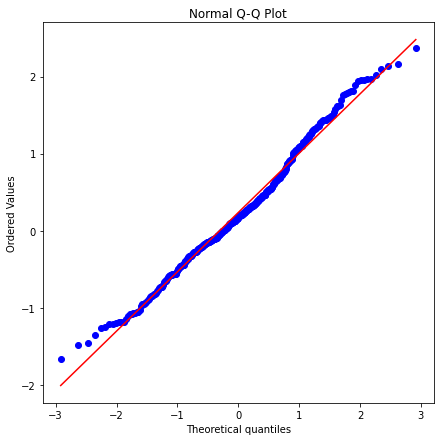

In [33]:
plt.figure(figsize=(7,7))
stats.probplot(target_test-test_predictions, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")


<AxesSubplot:>

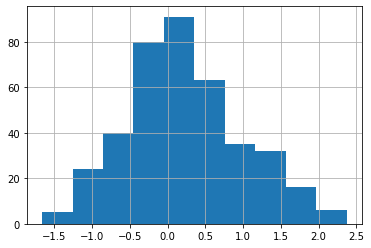

In [29]:
(target_test-test_predictions).hist()

C:\Users\cheta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 0, 'Fitted value')

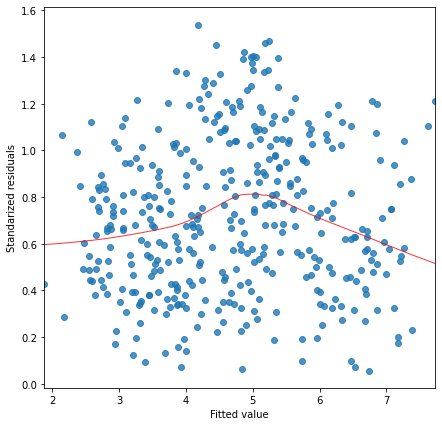

In [34]:
residuals = target_test-test_predictions
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(test_predictions, model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")

## Random Forest

In [35]:
# Instantiate model with 1000 decision trees
rf_model = RandomForestRegressor(n_estimators = 1000,max_depth=5, random_state = 42)# Train the model on training data
rf_model.fit(X_training_data, target_train);

In [36]:
rf_predictions = rf_model.predict(X_testing_data)

In [ ]:
X_testing_new

C:\Users\cheta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Residual plot')

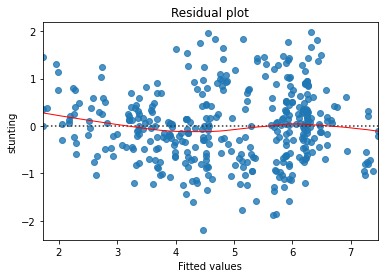

In [37]:
sns.residplot(rf_predictions,target_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Mean Absolute Error: 0.6 degrees.


Text(0.5, 1.0, 'Normal Q-Q Plot')

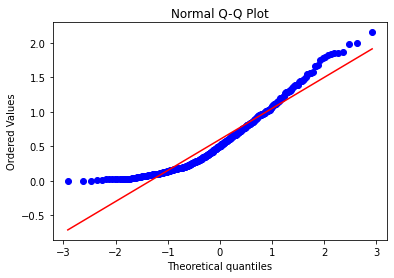

In [38]:
errors = abs(rf_predictions - target_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

<AxesSubplot:>

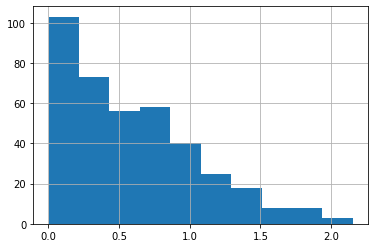

In [39]:
(errors).hist()

In [40]:
mape = 100 * (errors / target_test)# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 86.66 %.


In [41]:
print('Mean Absolute Error:', metrics.mean_absolute_error(target_test,rf_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(target_test,rf_predictions))

Mean Absolute Error: 0.6011002665820849
Mean Squared Error: 0.5772120047323525


In [ ]:
rf_model

In [ ]:
from sklearn.tree import export_graphviz
import pydot# Pull out one tree from the forest
tree = rf_model.estimators_[5]# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = X_training_data.columns, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')